### Kernal Used: Python 2016 Python 3
#### PUI Extra Credit: ep2247

In [1]:
from __future__ import print_function, division
import os
import pandas as pd
import numpy as np
import pylab as pl
%pylab inline
import geopandas as gpd
import fiona
import shapely
from shapely.geometry import Point
import urllib
import requests
import io
import json
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm
from censusAPI import myAPI

Populating the interactive namespace from numpy and matplotlib


In [2]:
PUIDATA = os.getenv("PUIDATA")
print(PUIDATA)

/home/cusp/ep2247/PUIdata


#### Read in August Taxi Data

In [3]:
taxiAug = pd.read_csv(PUIDATA + '/Aug2016_taxidata.csv')

In [4]:
print ("the original dataset is {:d} observations by {:d} variables".\
           format(*taxiAug.shape))

the original dataset is 9942263 observations by 21 variables


##### Reducing the size of the August taxi data and cleaning it

In [5]:
taxiAug_short = taxiAug[::500]
taxiAug_short.head()

,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PULocationID,DOLocationID
0,2,08/01/2016 12:00:00 AM,08/01/2016 04:58:59 PM,1,23.43,NaN,NaN,2,N,NaN,...,2,52.0,0.3,0.5,0.00,5.54,0.3,58.64,239,132
500,1,08/01/2016 12:03:19 AM,08/01/2016 12:11:53 AM,1,2.30,NaN,NaN,1,N,NaN,...,1,9.5,0.5,0.5,2.15,0.00,0.3,12.95,142,41
1000,1,08/01/2016 12:06:58 AM,08/01/2016 12:17:17 AM,3,2.20,NaN,NaN,1,N,NaN,...,2,9.5,0.5,0.5,0.00,0.00,0.3,10.80,239,166
1500,2,08/01/2016 12:10:37 AM,08/01/2016 12:19:38 AM,1,2.55,NaN,NaN,1,N,NaN,...,1,10.0,0.5,0.5,2.26,0.00,0.3,13.56,148,80
2000,2,08/01/2016 12:14:04 AM,08/01/2016 12:19:22 AM,5,1.49,NaN,NaN,1,N,NaN,...,2,6.5,0.5,0.5,0.00,0.00,0.3,7.80,230,68


In [6]:

print ("the reducted dataset is {:d} observations by {:d} variables".\
       format(*taxiAug_short.shape))

the reducted dataset is 19885 observations by 21 variables


In [7]:
taxiAug_short.dtypes

﻿VendorID                  int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RatecodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
PULocationID               int64
DOLocationID               int64
dtype: object

In [8]:
# create total trip duration from pick up and drop off times

taxiAug_short['tripDuration'] = (pd.to_datetime(
    taxiAug_short['tpep_dropoff_datetime']) - pd.to_datetime(
    taxiAug_short['tpep_pickup_datetime'])).dt.seconds / 60
taxiAug_short.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PULocationID,DOLocationID,tripDuration
0,2,08/01/2016 12:00:00 AM,08/01/2016 04:58:59 PM,1,23.43,NaN,NaN,2,N,NaN,...,52.0,0.3,0.5,0.00,5.54,0.3,58.64,239,132,1018.983333
500,1,08/01/2016 12:03:19 AM,08/01/2016 12:11:53 AM,1,2.30,NaN,NaN,1,N,NaN,...,9.5,0.5,0.5,2.15,0.00,0.3,12.95,142,41,8.566667
1000,1,08/01/2016 12:06:58 AM,08/01/2016 12:17:17 AM,3,2.20,NaN,NaN,1,N,NaN,...,9.5,0.5,0.5,0.00,0.00,0.3,10.80,239,166,10.316667
1500,2,08/01/2016 12:10:37 AM,08/01/2016 12:19:38 AM,1,2.55,NaN,NaN,1,N,NaN,...,10.0,0.5,0.5,2.26,0.00,0.3,13.56,148,80,9.016667
2000,2,08/01/2016 12:14:04 AM,08/01/2016 12:19:22 AM,5,1.49,NaN,NaN,1,N,NaN,...,6.5,0.5,0.5,0.00,0.00,0.3,7.80,230,68,5.300000


In [9]:
taxiAug_short['tpep_dropoff_datetime'] = pd.to_datetime(
    taxiAug_short['tpep_dropoff_datetime'])
taxiAug_short['tpep_pickup_datetime'] = pd.to_datetime(
    taxiAug_short['tpep_pickup_datetime'])

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
#drop columns from August Taxi Dataset

taxiAug_short.drop(['RatecodeID','store_and_fwd_flag',
                   'payment_type','fare_amount','extra','mta_tax',
                   'tip_amount','tolls_amount','improvement_surcharge'],inplace = True, axis = 1)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
taxiAug_long = taxiAug_short.loc[taxiAug_short['trip_distance'] > 2.0]
taxiAug_long.head()

,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,tripDuration
0,2,2016-08-01 00:00:00,2016-08-01 16:58:59,1,23.43,NaN,NaN,NaN,NaN,58.64,239,132,1018.983333
500,1,2016-08-01 00:03:19,2016-08-01 00:11:53,1,2.30,NaN,NaN,NaN,NaN,12.95,142,41,8.566667
1000,1,2016-08-01 00:06:58,2016-08-01 00:17:17,3,2.20,NaN,NaN,NaN,NaN,10.80,239,166,10.316667
1500,2,2016-08-01 00:10:37,2016-08-01 00:19:38,1,2.55,NaN,NaN,NaN,NaN,13.56,148,80,9.016667
3000,1,2016-08-01 00:20:58,2016-08-01 00:32:34,1,3.00,NaN,NaN,NaN,NaN,12.80,7,129,11.600000


In [14]:
print ("the long distance dataset is {:d} observations by {:d} variables".\
       format(*taxiAug_long.shape))

the long distance dataset is 8426 observations by 13 variables


In [15]:
taxiAug_short = taxiAug_short.loc[taxiAug_short['trip_distance'] <= 2.0]
taxiAug_short.head()

,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,tripDuration
2000,2,2016-08-01 00:14:04,2016-08-01 00:19:22,5,1.49,NaN,NaN,NaN,NaN,7.80,230,68,5.300000
2500,1,2016-08-01 00:17:27,2016-08-01 00:23:49,2,1.20,NaN,NaN,NaN,NaN,7.80,137,233,6.366667
3500,1,2016-08-01 00:24:54,2016-08-01 00:30:18,1,0.40,NaN,NaN,NaN,NaN,16.30,230,48,5.400000
4000,1,2016-08-01 00:28:49,2016-08-01 00:36:33,1,1.40,NaN,NaN,NaN,NaN,10.55,148,107,7.733333
10000,1,2016-08-01 01:25:31,2016-08-01 01:32:54,1,1.40,NaN,NaN,NaN,NaN,8.39,186,170,7.383333


#### Read in January Taxi Data

In [16]:
taxiJan = pd.read_csv(PUIDATA + '/Jan2016_taxidata.csv')

In [17]:
print ("the original dataset is {:d} observations by {:d} variables".\
           format(*taxiJan.shape))

the original dataset is 10906858 observations by 21 variables


##### Reducing the size of the data for easier development

In [18]:
taxiJan_short = taxiJan[::500]
taxiJan_short.head()

,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PULocationID,DOLocationID
0,2,01/01/2016 12:00:00 AM,01/01/2016 12:18:30 AM,2,5.52,-73.980118,40.743050,1,N,-73.913490,...,2,19.0,0.5,0.5,0.0,0.0,0.3,20.3,NaN,NaN
500,1,01/01/2016 12:04:00 AM,01/01/2016 12:11:57 AM,2,2.20,0.000000,0.000000,1,Y,0.000000,...,1,9.0,0.5,0.5,1.0,0.0,0.3,11.3,NaN,NaN
1000,2,01/01/2016 12:06:17 AM,01/01/2016 12:19:05 AM,5,1.67,-73.969994,40.753117,1,N,-73.991417,...,2,9.5,0.5,0.5,0.0,0.0,0.3,10.8,NaN,NaN
1500,1,01/01/2016 12:08:00 AM,01/01/2016 12:37:50 AM,1,4.70,-73.990311,40.761776,1,N,-73.992653,...,2,22.5,0.5,0.5,0.0,0.0,0.3,23.8,NaN,NaN
2000,2,01/01/2016 12:09:29 AM,01/01/2016 12:31:53 AM,6,3.20,-73.987320,40.768543,1,N,-73.979561,...,1,16.0,0.5,0.5,2.0,0.0,0.3,19.3,NaN,NaN


In [19]:
print ("the reducted dataset is {:d} observations by {:d} variables".\
       format(*taxiJan_short.shape))

the reducted dataset is 21814 observations by 21 variables


In [20]:
# create total trip duration from pick up and drop off times

taxiJan_short['tripDuration'] = (pd.to_datetime(
    taxiJan_short['tpep_dropoff_datetime']) - pd.to_datetime(
    taxiJan_short['tpep_pickup_datetime'])).dt.seconds / 60
taxiJan_short.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,PULocationID,DOLocationID,tripDuration
0,2,01/01/2016 12:00:00 AM,01/01/2016 12:18:30 AM,2,5.52,-73.980118,40.743050,1,N,-73.913490,...,19.0,0.5,0.5,0.0,0.0,0.3,20.3,NaN,NaN,18.500000
500,1,01/01/2016 12:04:00 AM,01/01/2016 12:11:57 AM,2,2.20,0.000000,0.000000,1,Y,0.000000,...,9.0,0.5,0.5,1.0,0.0,0.3,11.3,NaN,NaN,7.950000
1000,2,01/01/2016 12:06:17 AM,01/01/2016 12:19:05 AM,5,1.67,-73.969994,40.753117,1,N,-73.991417,...,9.5,0.5,0.5,0.0,0.0,0.3,10.8,NaN,NaN,12.800000
1500,1,01/01/2016 12:08:00 AM,01/01/2016 12:37:50 AM,1,4.70,-73.990311,40.761776,1,N,-73.992653,...,22.5,0.5,0.5,0.0,0.0,0.3,23.8,NaN,NaN,29.833333
2000,2,01/01/2016 12:09:29 AM,01/01/2016 12:31:53 AM,6,3.20,-73.987320,40.768543,1,N,-73.979561,...,16.0,0.5,0.5,2.0,0.0,0.3,19.3,NaN,NaN,22.400000


In [21]:
taxiJan_short['tpep_dropoff_datetime'] = pd.to_datetime(
    taxiJan_short['tpep_dropoff_datetime'])
taxiJan_short['tpep_pickup_datetime'] = pd.to_datetime(
    taxiJan_short['tpep_pickup_datetime'])

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
#drop columns from August Taxi Dataset

taxiJan_short.drop(['RatecodeID','store_and_fwd_flag',
                   'payment_type','fare_amount','extra','mta_tax',
                   'tip_amount','tolls_amount','improvement_surcharge'],
                  inplace = True, axis = 1)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
taxiJan_long = taxiJan_short.loc[taxiJan_short['trip_distance'] > 2.0]
taxiJan_long.head()

,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,tripDuration
0,2,2016-01-01 00:00:00,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,-73.913490,40.763142,20.30,NaN,NaN,18.500000
500,1,2016-01-01 00:04:00,2016-01-01 00:11:57,2,2.20,0.000000,0.000000,0.000000,0.000000,11.30,NaN,NaN,7.950000
1500,1,2016-01-01 00:08:00,2016-01-01 00:37:50,1,4.70,-73.990311,40.761776,-73.992653,40.712326,23.80,NaN,NaN,29.833333
2000,2,2016-01-01 00:09:29,2016-01-01 00:31:53,6,3.20,-73.987320,40.768543,-73.979561,40.783676,19.30,NaN,NaN,22.400000
2500,2,2016-01-01 00:10:54,2016-01-01 00:35:03,1,2.38,-73.978539,40.759949,-73.994476,40.758209,20.76,NaN,NaN,24.150000


In [25]:
print ("the long distance dataset is {:d} observations by {:d} variables".\
       format(*taxiAug_long.shape))

the long distance dataset is 8426 observations by 13 variables


In [26]:
#selecting all trip distances that are less then 2 miles
taxiJan_short = taxiJan_short.loc[taxiJan_short['trip_distance'] <= 2.0]
taxiJan_short.head()

,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,tripDuration
1000,2,2016-01-01 00:06:17,2016-01-01 00:19:05,5,1.67,-73.969994,40.753117,-73.991417,40.748997,10.80,NaN,NaN,12.800000
3000,2,2016-01-01 00:12:11,2016-01-01 00:20:46,1,1.35,-73.977692,40.749634,-73.967064,40.758446,10.56,NaN,NaN,8.583333
5000,2,2016-01-01 00:16:57,2016-01-01 00:29:30,1,1.57,-73.973869,40.757099,-73.988098,40.737961,10.80,NaN,NaN,12.550000
5500,1,2016-01-01 00:18:08,2016-01-01 00:19:35,4,0.30,-73.923592,40.686687,-73.923386,40.690090,4.30,NaN,NaN,1.450000
6500,2,2016-01-01 00:20:21,2016-01-01 00:25:05,1,1.11,-73.976433,40.780781,-73.969398,40.790253,8.84,NaN,NaN,4.733333


#### Read in August weather data

In [27]:
wxAug = pd.read_csv(PUIDATA + '/Aug2016WeatherData.csv')
wxAug.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,REPORTTPYE,HOURLYSKYCONDITIONS,HOURLYVISIBILITY,HOURLYPRSENTWEATHERTYPE,...,MonthlyMaxSeaLevelPressureTime,MonthlyMinSeaLevelPressureValue,MonthlyMinSeaLevelPressureDate,MonthlyMinSeaLevelPressureTime,MonthlyTotalHeatingDegreeDays,MonthlyTotalCoolingDegreeDays,MonthlyDeptFromNormalHeatingDD,MonthlyDeptFromNormalCoolingDD,MonthlyTotalSeasonToDateHeatingDD,MonthlyTotalSeasonToDateCoolingDD
0,WBAN:94728,NY CITY CENTRAL PARK NY US,42.7,40.77898,-73.96925,2016-08-01 00:51,FM-15,OVC:08 8,8.00,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
1,WBAN:94728,NY CITY CENTRAL PARK NY US,42.7,40.77898,-73.96925,2016-08-01 01:51,FM-15,OVC:08 7,7.00,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
2,WBAN:94728,NY CITY CENTRAL PARK NY US,42.7,40.77898,-73.96925,2016-08-01 02:31,FM-16,BKN:07 10 OVC:08 19,9.00,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
3,WBAN:94728,NY CITY CENTRAL PARK NY US,42.7,40.77898,-73.96925,2016-08-01 02:51,FM-15,BKN:07 11 OVC:08 20,9.00,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
4,WBAN:94728,NY CITY CENTRAL PARK NY US,42.7,40.77898,-73.96925,2016-08-01 03:18,FM-16,OVC:08 9,9.00,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
print ("the original dataset is {:d} observations by {:d} variables".\
           format(*wxAug.shape))

the original dataset is 894 observations by 90 variables


In [29]:
wxAugDaily = wxAug[wxAug['REPORTTPYE'] == 'SOD']
wxAugDaily.head(1)

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,REPORTTPYE,HOURLYSKYCONDITIONS,HOURLYVISIBILITY,HOURLYPRSENTWEATHERTYPE,...,MonthlyMaxSeaLevelPressureTime,MonthlyMinSeaLevelPressureValue,MonthlyMinSeaLevelPressureDate,MonthlyMinSeaLevelPressureTime,MonthlyTotalHeatingDegreeDays,MonthlyTotalCoolingDegreeDays,MonthlyDeptFromNormalHeatingDD,MonthlyDeptFromNormalCoolingDD,MonthlyTotalSeasonToDateHeatingDD,MonthlyTotalSeasonToDateCoolingDD
41,WBAN:94728,NY CITY CENTRAL PARK NY US,42.7,40.77898,-73.96925,2016-08-01 23:59,SOD,NaN,NaN,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
wxAugDaily.drop(['STATION','STATION_NAME','ELEVATION','LATITUDE',
                'LONGITUDE','HOURLYSKYCONDITIONS','HOURLYVISIBILITY',
                'HOURLYPRSENTWEATHERTYPE','HOURLYDRYBULBTEMPF',
                'HOURLYDRYBULBTEMPC','HOURLYWETBULBTEMPF',
                 'HOURLYWETBULBTEMPC','HOURLYDewPointTempF',
                'HOURLYDewPointTempC', 'HOURLYRelativeHumidity',
                 'HOURLYWindSpeed','HOURLYWindDirection',
                 'HOURLYWindGustSpeed', 'HOURLYStationPressure',
                'HOURLYPressureTendency', 'HOURLYPressureChange',
                 'HOURLYSeaLevelPressure', 'HOURLYPrecip', 
                 'HOURLYAltimeterSetting','MonthlyMaximumTemp', 
                'MonthlyMinimumTemp', 'MonthlyMeanTemp',
                'MonthlyAverageRH', 'MonthlyDewpointTemp', 
                'MonthlyWetBulbTemp', 'MonthlyAvgHeatingDegreeDays', 
                'MonthlyAvgCoolingDegreeDays', 'MonthlyStationPressure', 
                'MonthlySeaLevelPressure','MonthlyAverageWindSpeed',
                'MonthlyTotalSnowfall','MonthlyDeptFromNormalMaximumTemp',
                'MonthlyDeptFromNormalMinimumTemp', 
                'MonthlyDeptFromNormalAverageTemp', 
                'MonthlyDeptFromNormalPrecip', 'MonthlyTotalLiquidPrecip', 
                'MonthlyGreatestPrecip',  'MonthlyGreatestPrecipDate', 
                'MonthlyGreatestSnowfall', 'MonthlyGreatestSnowfallDate', 
                'MonthlyGreatestSnowDepth', 'MonthlyGreatestSnowDepthDate',
                'MonthlyDaysWithGT90Temp','MonthlyDaysWithLT32Temp', 
                'MonthlyDaysWithGT32Temp','MonthlyDaysWithLT0Temp', 
                'MonthlyDaysWithGT001Precip','MonthlyDaysWithGT010Precip',
                'MonthlyDaysWithGT1Snow', 'MonthlyMaxSeaLevelPressureValue',
                'MonthlyMaxSeaLevelPressureDate',  'MonthlyMaxSeaLevelPressureTime', 
                'MonthlyMinSeaLevelPressureValue', 'MonthlyMinSeaLevelPressureDate', 
                'MonthlyMinSeaLevelPressureTime', 'MonthlyTotalHeatingDegreeDays',
                'MonthlyTotalCoolingDegreeDays', 'MonthlyDeptFromNormalHeatingDD',
                'MonthlyDeptFromNormalCoolingDD','MonthlyTotalSeasonToDateHeatingDD'
                , 'MonthlyTotalSeasonToDateCoolingDD','DAILYSunrise',
                 'DAILYSunset','DAILYAverageStationPressure',
                 'DAILYAverageSeaLevelPressure',
                'PeakWindDirection', 'DAILYSustainedWindSpeed',
                'DAILYSustainedWindDirection', 'DAILYWeather',
                 'DAILYSnowDepth','DAILYHeatingDegreeDays',
                 'DAILYCoolingDegreeDays',
                 'DAILYDeptFromNormalAverageTemp','REPORTTPYE',
                'DAILYAverageDryBulbTemp','DAILYAverageRelativeHumidity',
                'DAILYAverageDewPointTemp', 'DAILYAverageWetBulbTemp',
                 'DAILYAverageWindSpeed', 'DAILYPeakWindSpeed'],
                inplace = True,axis = 1)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [31]:
wxAugDaily.head()

,DATE,DAILYMaximumDryBulbTemp,DAILYMinimumDryBulbTemp,DAILYPrecip,DAILYSnowfall
41,2016-08-01 23:59,80.0,69.0,T,0.0
72,2016-08-02 23:59,79.0,68.0,0.00,0.0
97,2016-08-03 23:59,80.0,66.0,0.00,0.0
124,2016-08-04 23:59,81.0,67.0,0.00,0.0
149,2016-08-05 23:59,83.0,69.0,0.00,0.0


In [32]:
wxAugDaily.columns = ['date','highTemp','lowTemp','precip','snow']

In [33]:
# change Trace (T) to 0.005
wxAugDaily.precip = wxAugDaily.precip.replace('T',0.005)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [34]:
wxAugDaily['date'] = pd.to_datetime(wxAugDaily['date'])
wxAugDaily.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,date,highTemp,lowTemp,precip,snow
41,2016-08-01 23:59:00,80.0,69.0,0.005,0.0
72,2016-08-02 23:59:00,79.0,68.0,0.00,0.0
97,2016-08-03 23:59:00,80.0,66.0,0.00,0.0
124,2016-08-04 23:59:00,81.0,67.0,0.00,0.0
149,2016-08-05 23:59:00,83.0,69.0,0.00,0.0


#### Read in January Weather Data

In [35]:
wxJan = pd.read_csv(PUIDATA + '/Jan2016WeatherData.csv')
wxJan.head()

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,REPORTTPYE,HOURLYSKYCONDITIONS,HOURLYVISIBILITY,HOURLYPRSENTWEATHERTYPE,...,MonthlyMaxSeaLevelPressureTime,MonthlyMinSeaLevelPressureValue,MonthlyMinSeaLevelPressureDate,MonthlyMinSeaLevelPressureTime,MonthlyTotalHeatingDegreeDays,MonthlyTotalCoolingDegreeDays,MonthlyDeptFromNormalHeatingDD,MonthlyDeptFromNormalCoolingDD,MonthlyTotalSeasonToDateHeatingDD,MonthlyTotalSeasonToDateCoolingDD
0,WBAN:94728,NY CITY CENTRAL PARK NY US,42.7,40.77898,-73.96925,2016-01-01 00:51,FM-15,OVC:08 37,10.00,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
1,WBAN:94728,NY CITY CENTRAL PARK NY US,42.7,40.77898,-73.96925,2016-01-01 01:51,FM-15,OVC:08 36,10.00,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
2,WBAN:94728,NY CITY CENTRAL PARK NY US,42.7,40.77898,-73.96925,2016-01-01 02:51,FM-15,OVC:08 34,10.00,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
3,WBAN:94728,NY CITY CENTRAL PARK NY US,42.7,40.77898,-73.96925,2016-01-01 03:51,FM-15,OVC:08 31,10.00,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN
4,WBAN:94728,NY CITY CENTRAL PARK NY US,42.7,40.77898,-73.96925,2016-01-01 04:51,FM-15,OVC:08 44,10.00,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
print ("the original dataset is {:d} observations by {:d} variables".\
           format(*wxJan.shape))

the original dataset is 891 observations by 90 variables


In [37]:
wxJanDaily = wxJan[wxJan['REPORTTPYE'] == 'SOD']
wxJanDaily.head(1)

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,REPORTTPYE,HOURLYSKYCONDITIONS,HOURLYVISIBILITY,HOURLYPRSENTWEATHERTYPE,...,MonthlyMaxSeaLevelPressureTime,MonthlyMinSeaLevelPressureValue,MonthlyMinSeaLevelPressureDate,MonthlyMinSeaLevelPressureTime,MonthlyTotalHeatingDegreeDays,MonthlyTotalCoolingDegreeDays,MonthlyDeptFromNormalHeatingDD,MonthlyDeptFromNormalCoolingDD,MonthlyTotalSeasonToDateHeatingDD,MonthlyTotalSeasonToDateCoolingDD
24,WBAN:94728,NY CITY CENTRAL PARK NY US,42.7,40.77898,-73.96925,2016-01-01 23:59,SOD,NaN,NaN,NaN,...,-9999,NaN,-9999,-9999,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
wxJanDaily.drop(['STATION','STATION_NAME','ELEVATION','LATITUDE',
                'LONGITUDE','HOURLYSKYCONDITIONS','HOURLYVISIBILITY',
                'HOURLYPRSENTWEATHERTYPE','HOURLYDRYBULBTEMPF',
                'HOURLYDRYBULBTEMPC','HOURLYWETBULBTEMPF',
                 'HOURLYWETBULBTEMPC','HOURLYDewPointTempF',
                'HOURLYDewPointTempC', 'HOURLYRelativeHumidity',
                 'HOURLYWindSpeed','HOURLYWindDirection',
                 'HOURLYWindGustSpeed', 'HOURLYStationPressure',
                'HOURLYPressureTendency', 'HOURLYPressureChange',
                 'HOURLYSeaLevelPressure', 'HOURLYPrecip', 
                 'HOURLYAltimeterSetting','MonthlyMaximumTemp', 
                'MonthlyMinimumTemp', 'MonthlyMeanTemp',
                'MonthlyAverageRH', 'MonthlyDewpointTemp', 
                'MonthlyWetBulbTemp', 'MonthlyAvgHeatingDegreeDays', 
                'MonthlyAvgCoolingDegreeDays', 'MonthlyStationPressure', 
                'MonthlySeaLevelPressure','MonthlyAverageWindSpeed',
                'MonthlyTotalSnowfall','MonthlyDeptFromNormalMaximumTemp',
                'MonthlyDeptFromNormalMinimumTemp', 
                'MonthlyDeptFromNormalAverageTemp', 
                'MonthlyDeptFromNormalPrecip', 'MonthlyTotalLiquidPrecip', 
                'MonthlyGreatestPrecip',  'MonthlyGreatestPrecipDate', 
                'MonthlyGreatestSnowfall', 'MonthlyGreatestSnowfallDate', 
                'MonthlyGreatestSnowDepth', 'MonthlyGreatestSnowDepthDate',
                'MonthlyDaysWithGT90Temp','MonthlyDaysWithLT32Temp', 
                'MonthlyDaysWithGT32Temp','MonthlyDaysWithLT0Temp', 
                'MonthlyDaysWithGT001Precip','MonthlyDaysWithGT010Precip',
                'MonthlyDaysWithGT1Snow', 'MonthlyMaxSeaLevelPressureValue',
                'MonthlyMaxSeaLevelPressureDate',  'MonthlyMaxSeaLevelPressureTime', 
                'MonthlyMinSeaLevelPressureValue', 'MonthlyMinSeaLevelPressureDate', 
                'MonthlyMinSeaLevelPressureTime', 'MonthlyTotalHeatingDegreeDays',
                'MonthlyTotalCoolingDegreeDays', 'MonthlyDeptFromNormalHeatingDD',
                'MonthlyDeptFromNormalCoolingDD','MonthlyTotalSeasonToDateHeatingDD'
                , 'MonthlyTotalSeasonToDateCoolingDD','DAILYSunrise',
                 'DAILYSunset','DAILYAverageStationPressure',
                 'DAILYAverageSeaLevelPressure',
                'PeakWindDirection', 'DAILYSustainedWindSpeed',
                'DAILYSustainedWindDirection', 'DAILYWeather',
                 'DAILYSnowDepth','DAILYHeatingDegreeDays',
                 'DAILYCoolingDegreeDays',
                 'DAILYDeptFromNormalAverageTemp','REPORTTPYE',
                'DAILYAverageDryBulbTemp','DAILYAverageRelativeHumidity',
                'DAILYAverageDewPointTemp', 'DAILYAverageWetBulbTemp',
                 'DAILYAverageWindSpeed', 'DAILYPeakWindSpeed'],
                inplace = True,axis = 1)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [39]:
wxJanDaily.columns = ['date','highTemp','lowTemp','precip','snow']
wxJanDaily.head()

,date,highTemp,lowTemp,precip,snow
24,2016-01-01 23:59,42.0,34.0,0.00,0.0
49,2016-01-02 23:59,40.0,32.0,0.00,0.0
74,2016-01-03 23:59,45.0,35.0,0.00,0.0
99,2016-01-04 23:59,36.0,14.0,0.00,0.0
124,2016-01-05 23:59,29.0,11.0,0.00,0.0


In [40]:
# change Trace (T) to 0.005
wxJanDaily.precip = wxJanDaily.precip.replace('T',0.005)
wxJanDaily.snow = wxJanDaily.snow.replace('T',0.005)
wxJanDaily.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,date,highTemp,lowTemp,precip,snow
24,2016-01-01 23:59,42.0,34.0,0.00,0.0
49,2016-01-02 23:59,40.0,32.0,0.00,0.0
74,2016-01-03 23:59,45.0,35.0,0.00,0.0
99,2016-01-04 23:59,36.0,14.0,0.00,0.0
124,2016-01-05 23:59,29.0,11.0,0.00,0.0


#### Read in taxi zone shapefile

In [41]:
taxiZoneshp = gpd.read_file(PUIDATA + '/taxi_zones.shp')
taxiZoneshp.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.9183527103 192536.0856972019,..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"(POLYGON ((1033269.243591294 172126.0078125, 1..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.769506663 256767.6975403726,..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.3104932606 144283.335850656, ..."


In [42]:
print ("the original dataset is {:d} observations by {:d} variables".\
           format(*taxiZoneshp.shape))

the original dataset is 263 observations by 7 variables


In [43]:
to_drop = ['Newark Airport', 'JFK Airport','LaGuardia Airport']
taxiZoneFinal = taxiZoneshp[~taxiZoneshp['zone'].isin(to_drop)]

In [44]:
print ("the original dataset is {:d} observations by {:d} variables".\
           format(*taxiZoneFinal.shape))

the original dataset is 260 observations by 7 variables


#### Merge Data together and plot

##### Merge August Taxi and Taxi shapeilfe and plot the pickup locations

In [45]:
# Merge Aug Taxi and Taxi zone shapefile together

augShp =  taxiZoneFinal.merge(taxiAug_short, right_on = 'PULocationID',
                             left_on = 'LocationID')
augShp.columns

Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'LocationID', 'borough',
       'geometry', '﻿VendorID', 'tpep_pickup_datetime',
       'tpep_dropoff_datetime', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'total_amount', 'PULocationID', 'DOLocationID',
       'tripDuration'],
      dtype='object')

In [46]:
augShp.drop(['pickup_longitude','pickup_latitude','dropoff_longitude',
            'dropoff_latitude'],inplace = True, axis = 1)
augShp.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,total_amount,PULocationID,DOLocationID,tripDuration
0,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",2,2016-08-01 08:50:38,2016-08-01 08:55:54,5,1.04,8.50,4,79,5.266667
1,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",2,2016-08-04 09:57:09,2016-08-04 10:10:26,1,1.81,11.30,4,90,13.283333
2,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",1,2016-08-05 02:28:31,2016-08-05 02:30:52,1,0.40,5.30,4,224,2.350000
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",1,2016-08-06 02:46:37,2016-08-06 02:47:29,1,0.10,4.56,4,4,0.866667
4,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",2,2016-08-06 23:22:05,2016-08-06 23:27:16,5,0.71,7.88,4,79,5.183333


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


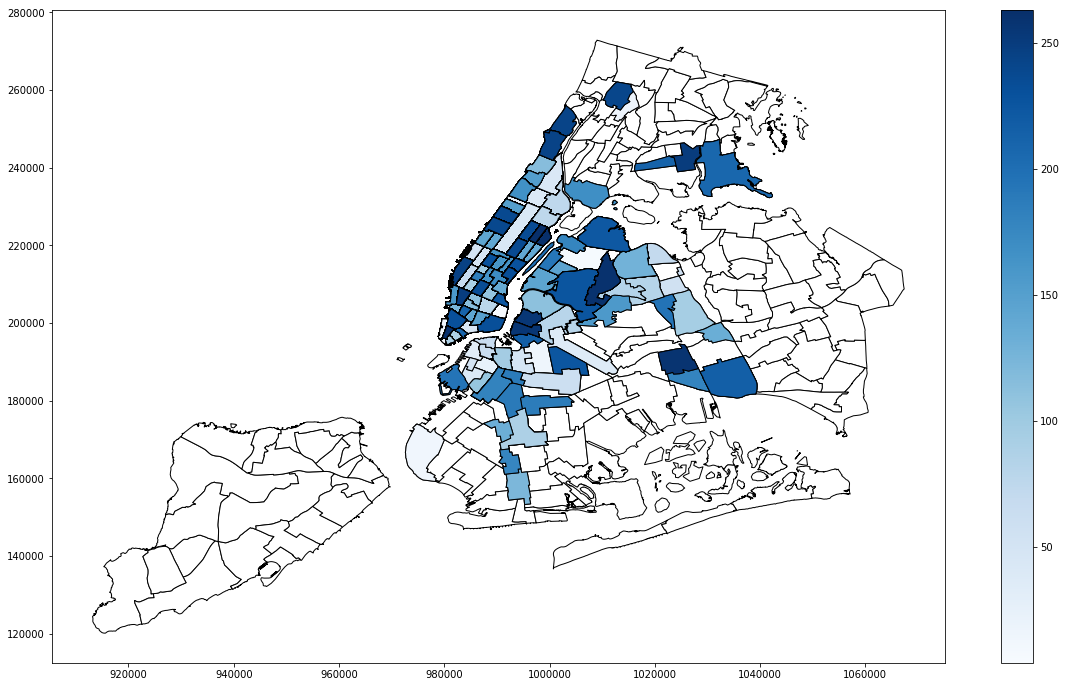

In [47]:
fig = pl.figure(figsize = (20,12))
ax = fig.add_subplot(111)

taxiZoneFinal.plot(ax = ax, column = 'LocationID', color = 'white',
                  edgecolor = 'black')

augShp.plot(ax = ax,column = 'PULocationID', cmap = 'Blues',
            edgecolor = 'black',legend = True)

##### Figure 1: Map of August pickups for trips less then 2 miles.  In this map, you only see the number of pickups per taxi zone.  Upper east side, Bronx, parts of Queens and Brooklyn are more prone to take taxi trips that are less then 2 miles.  There are a high number of people prone to take taxi trips that are picked up in the Bronx compared to the other boroughs

In [48]:
augShp = gpd.GeoDataFrame(augShp, geometry = 'geometry')
augShp.crs = {'init': 'epsg:4326'}
augShp.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,total_amount,PULocationID,DOLocationID,tripDuration
0,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",2,2016-08-01 08:50:38,2016-08-01 08:55:54,5,1.04,8.50,4,79,5.266667
1,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",2,2016-08-04 09:57:09,2016-08-04 10:10:26,1,1.81,11.30,4,90,13.283333
2,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",1,2016-08-05 02:28:31,2016-08-05 02:30:52,1,0.40,5.30,4,224,2.350000
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",1,2016-08-06 02:46:37,2016-08-06 02:47:29,1,0.10,4.56,4,4,0.866667
4,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",2,2016-08-06 23:22:05,2016-08-06 23:27:16,5,0.71,7.88,4,79,5.183333


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


Text(0.5,1,'August Taxi Ride Trip Distance less than 2 miles')

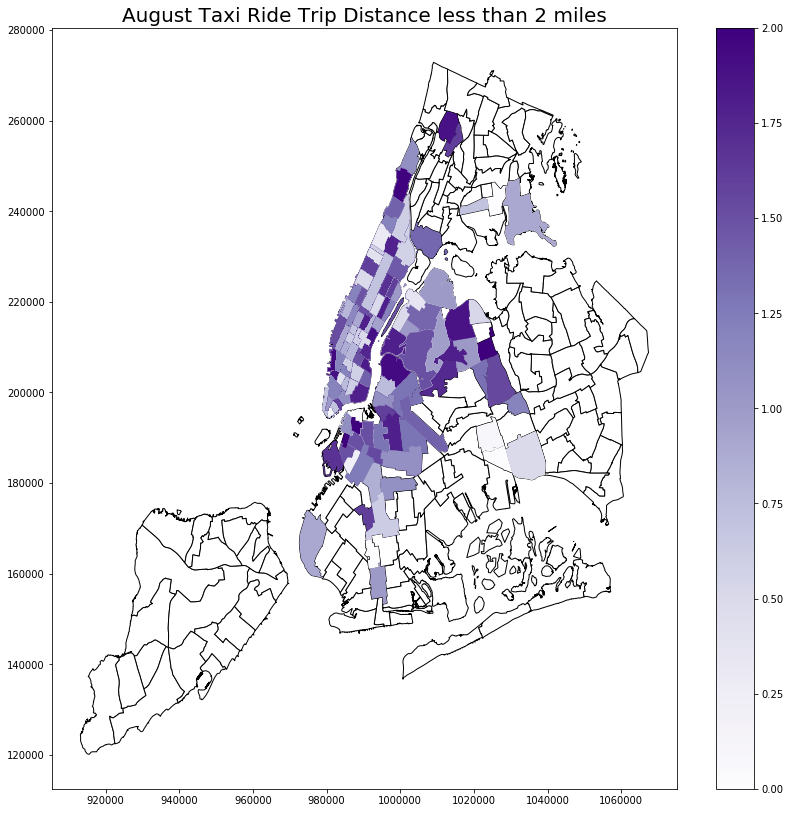

In [163]:
fig = pl.figure(figsize = (14,14))
ax = fig.add_subplot(111)

taxiZoneFinal.plot(ax = ax, column = 'LocationID', color = 'white',
                  edgecolor = 'black')

augShp.plot(ax = ax, column = 'trip_distance', cmap = 'Purples',
                   legend = True)
plt.title('August Taxi Ride Trip Distance less than 2 miles', fontsize = 20)

##### Figure 1: Short Trip Distances plotted for the month of August.

In [50]:
# convert January taxi short in a geopandas dataframe

taxiJan_short['geometry'] = taxiJan_short.apply(
    lambda row: Point(row["pickup_longitude"], row["pickup_latitude"]),
    axis=1)
taxiJan_short = gpd.GeoDataFrame(taxiJan_short, geometry = 'geometry')
taxiJan_short.crs = {'init': 'epsg:4326'}
taxiJan_short.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,tripDuration,geometry
1000,2,2016-01-01 00:06:17,2016-01-01 00:19:05,5,1.67,-73.969994,40.753117,-73.991417,40.748997,10.80,NaN,NaN,12.800000,POINT (-73.96999359130859 40.75311660766602)
3000,2,2016-01-01 00:12:11,2016-01-01 00:20:46,1,1.35,-73.977692,40.749634,-73.967064,40.758446,10.56,NaN,NaN,8.583333,POINT (-73.97769165039062 40.7496337890625)
5000,2,2016-01-01 00:16:57,2016-01-01 00:29:30,1,1.57,-73.973869,40.757099,-73.988098,40.737961,10.80,NaN,NaN,12.550000,POINT (-73.97386932373048 40.75709915161133)
5500,1,2016-01-01 00:18:08,2016-01-01 00:19:35,4,0.30,-73.923592,40.686687,-73.923386,40.690090,4.30,NaN,NaN,1.450000,POINT (-73.92359161376955 40.68668746948241)
6500,2,2016-01-01 00:20:21,2016-01-01 00:25:05,1,1.11,-73.976433,40.780781,-73.969398,40.790253,8.84,NaN,NaN,4.733333,POINT (-73.97643280029298 40.78078079223633)


In [51]:
#taxiJan_short = taxiJan_short[taxiJan_short['pickup_latitude'] != 0]
taxiJan_short = taxiJan_short[taxiJan_short['pickup_latitude'] > 40.6]
taxiJan_short = taxiJan_short[taxiJan_short['pickup_latitude'] < 40.9]
taxiJan_short = taxiJan_short[taxiJan_short['pickup_longitude'] < -73.8]
taxiJan_short

,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,tripDuration,geometry
1000,2,2016-01-01 00:06:17,2016-01-01 00:19:05,5,1.67,-73.969994,40.753117,-73.991417,40.748997,10.80,NaN,NaN,12.800000,POINT (-73.96999359130859 40.75311660766602)
3000,2,2016-01-01 00:12:11,2016-01-01 00:20:46,1,1.35,-73.977692,40.749634,-73.967064,40.758446,10.56,NaN,NaN,8.583333,POINT (-73.97769165039062 40.7496337890625)
5000,2,2016-01-01 00:16:57,2016-01-01 00:29:30,1,1.57,-73.973869,40.757099,-73.988098,40.737961,10.80,NaN,NaN,12.550000,POINT (-73.97386932373048 40.75709915161133)
5500,1,2016-01-01 00:18:08,2016-01-01 00:19:35,4,0.30,-73.923592,40.686687,-73.923386,40.690090,4.30,NaN,NaN,1.450000,POINT (-73.92359161376955 40.68668746948241)
6500,2,2016-01-01 00:20:21,2016-01-01 00:25:05,1,1.11,-73.976433,40.780781,-73.969398,40.790253,8.84,NaN,NaN,4.733333,POINT (-73.97643280029298 40.78078079223633)
8500,1,2016-01-01 00:24:43,2016-01-01 00:29:56,2,0.70,-73.951767,40.714836,-73.946655,40.707939,8.80,NaN,NaN,5.216667,POINT (-73.95176696777344 40.71483612060547)
9000,2,2016-01-01 00:25:49,2016-01-01 00:27:24,1,0.00,-74.004150,40.707390,-74.003998,40.707272,4.30,NaN,NaN,1.583333,POINT (-74.004150390625 40.70738983154297)
9500,2,2016-01-01 00:26:55,2016-01-02 00:22:22,5,0.60,-73.952827,40.803417,-73.952728,40.810501,5.80,NaN,NaN,1435.450000,POINT (-73.95282745361328 40.80341720581055)
11000,2,2016-01-01 00:30:10,2016-01-01 00:32:36,6,0.46,-73.994858,40.725636,-73.990227,40.729668,5.30,NaN,NaN,2.433333,POINT (-73.99485778808595 40.72563552856445)
14000,2,2016-01-01 00:36:33,2016-01-01 00:42:05,1,1.32,-74.001701,40.717331,-74.000954,40.731880,8.76,NaN,NaN,5.533333,POINT (-74.00170135498048 40.71733093261719)


Text(0.5,1,'January Taxi Rides Trip Distance less than 2 miles')

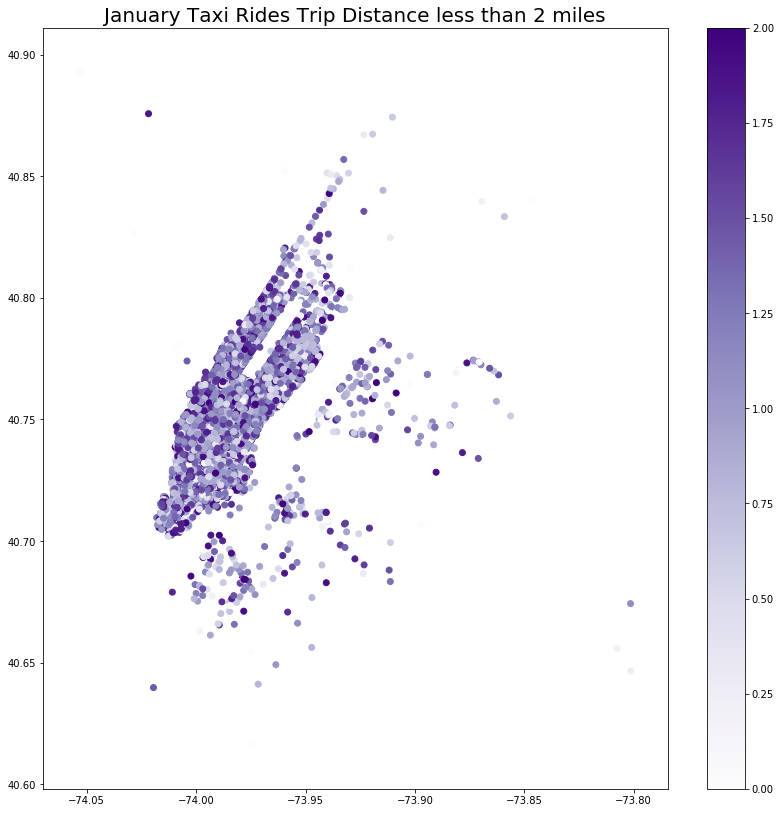

In [162]:
fig = pl.figure(figsize = (14,14))
ax = fig.add_subplot(111)


taxiJan_short.plot(ax = ax, column = 'trip_distance', cmap = 'Purples',
                   legend = True)
plt.title('January Taxi Rides Trip Distance less than 2 miles', fontsize = 20)

##### Figure 2: Short Trip Distances plotted for the month of January.

In [53]:
taxiAug_short.dtypes

﻿VendorID                         int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
pickup_longitude                float64
pickup_latitude                 float64
dropoff_longitude               float64
dropoff_latitude                float64
total_amount                    float64
PULocationID                      int64
DOLocationID                      int64
tripDuration                    float64
dtype: object

In [54]:
# merge august weather data with august taxi data but first create new 
# dataframes for each object so you only see date and not time

wxAugDaily['date'] = pd.to_datetime(wxAugDaily['date']).dt.date

#df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

taxiAug_short['tpep_pickup_datetime'] = pd.to_datetime(
    taxiAug_short['tpep_pickup_datetime']).dt.date

taxiAug_short['tpep_dropoff_datetime'] = pd.to_datetime(
    taxiAug_short['tpep_dropoff_datetime']).dt.date

taxiAug_short.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,tripDuration
2000,2,2016-08-01,2016-08-01,5,1.49,NaN,NaN,NaN,NaN,7.80,230,68,5.300000
2500,1,2016-08-01,2016-08-01,2,1.20,NaN,NaN,NaN,NaN,7.80,137,233,6.366667
3500,1,2016-08-01,2016-08-01,1,0.40,NaN,NaN,NaN,NaN,16.30,230,48,5.400000
4000,1,2016-08-01,2016-08-01,1,1.40,NaN,NaN,NaN,NaN,10.55,148,107,7.733333
10000,1,2016-08-01,2016-08-01,1,1.40,NaN,NaN,NaN,NaN,8.39,186,170,7.383333


In [55]:
wxAugDaily.head()

,date,highTemp,lowTemp,precip,snow
41,2016-08-01,80.0,69.0,0.005,0.0
72,2016-08-02,79.0,68.0,0.00,0.0
97,2016-08-03,80.0,66.0,0.00,0.0
124,2016-08-04,81.0,67.0,0.00,0.0
149,2016-08-05,83.0,69.0,0.00,0.0


In [56]:
# merge august weather and august taxi
augFinal = wxAugDaily.merge(taxiAug_short, right_on = 'tpep_pickup_datetime',
                             left_on = 'date')
augFinal.head()

,date,highTemp,lowTemp,precip,snow,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,tripDuration
0,2016-08-01,80.0,69.0,0.005,0.0,2,2016-08-01,2016-08-01,5,1.49,NaN,NaN,NaN,NaN,7.80,230,68,5.300000
1,2016-08-01,80.0,69.0,0.005,0.0,1,2016-08-01,2016-08-01,2,1.20,NaN,NaN,NaN,NaN,7.80,137,233,6.366667
2,2016-08-01,80.0,69.0,0.005,0.0,1,2016-08-01,2016-08-01,1,0.40,NaN,NaN,NaN,NaN,16.30,230,48,5.400000
3,2016-08-01,80.0,69.0,0.005,0.0,1,2016-08-01,2016-08-01,1,1.40,NaN,NaN,NaN,NaN,10.55,148,107,7.733333
4,2016-08-01,80.0,69.0,0.005,0.0,1,2016-08-01,2016-08-01,1,1.40,NaN,NaN,NaN,NaN,8.39,186,170,7.383333


In [57]:
augFinal.shape

(11459, 18)

In [58]:
augFinal.drop(['pickup_longitude','pickup_latitude','dropoff_longitude',
            'dropoff_latitude','lowTemp','snow','tpep_pickup_datetime',
              'tpep_dropoff_datetime','PULocationID','DOLocationID'],
              inplace = True, axis = 1)
augFinal.head()

,date,highTemp,precip,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration
0,2016-08-01,80.0,0.005,2,5,1.49,7.80,5.300000
1,2016-08-01,80.0,0.005,1,2,1.20,7.80,6.366667
2,2016-08-01,80.0,0.005,1,1,0.40,16.30,5.400000
3,2016-08-01,80.0,0.005,1,1,1.40,10.55,7.733333
4,2016-08-01,80.0,0.005,1,1,1.40,8.39,7.383333


In [59]:
# merge august weather data with august taxi data but first create new 
# dataframes for each object so you only see date and not time

wxJanDaily['date'] = pd.to_datetime(wxJanDaily['date']).dt.date

#df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

taxiJan_short['tpep_pickup_datetime'] = pd.to_datetime(
    taxiJan_short['tpep_pickup_datetime']).dt.date

taxiJan_short['tpep_dropoff_datetime'] = pd.to_datetime(
    taxiJan_short['tpep_dropoff_datetime']).dt.date

taxiJan_short.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,tripDuration,geometry
1000,2,2016-01-01,2016-01-01,5,1.67,-73.969994,40.753117,-73.991417,40.748997,10.80,NaN,NaN,12.800000,POINT (-73.96999359130859 40.75311660766602)
3000,2,2016-01-01,2016-01-01,1,1.35,-73.977692,40.749634,-73.967064,40.758446,10.56,NaN,NaN,8.583333,POINT (-73.97769165039062 40.7496337890625)
5000,2,2016-01-01,2016-01-01,1,1.57,-73.973869,40.757099,-73.988098,40.737961,10.80,NaN,NaN,12.550000,POINT (-73.97386932373048 40.75709915161133)
5500,1,2016-01-01,2016-01-01,4,0.30,-73.923592,40.686687,-73.923386,40.690090,4.30,NaN,NaN,1.450000,POINT (-73.92359161376955 40.68668746948241)
6500,2,2016-01-01,2016-01-01,1,1.11,-73.976433,40.780781,-73.969398,40.790253,8.84,NaN,NaN,4.733333,POINT (-73.97643280029298 40.78078079223633)


In [60]:
wxJanDaily.head()

,date,highTemp,lowTemp,precip,snow
24,2016-01-01,42.0,34.0,0.00,0.0
49,2016-01-02,40.0,32.0,0.00,0.0
74,2016-01-03,45.0,35.0,0.00,0.0
99,2016-01-04,36.0,14.0,0.00,0.0
124,2016-01-05,29.0,11.0,0.00,0.0


In [61]:
# merge january weather and january taxi
janFinal = wxJanDaily.merge(taxiJan_short, right_on = 'tpep_pickup_datetime',
                             left_on = 'date')
janFinal.head()

,date,highTemp,lowTemp,precip,snow,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,tripDuration,geometry
0,2016-01-01,42.0,34.0,0.00,0.0,2,2016-01-01,2016-01-01,5,1.67,-73.969994,40.753117,-73.991417,40.748997,10.80,NaN,NaN,12.800000,POINT (-73.96999359130859 40.75311660766602)
1,2016-01-01,42.0,34.0,0.00,0.0,2,2016-01-01,2016-01-01,1,1.35,-73.977692,40.749634,-73.967064,40.758446,10.56,NaN,NaN,8.583333,POINT (-73.97769165039062 40.7496337890625)
2,2016-01-01,42.0,34.0,0.00,0.0,2,2016-01-01,2016-01-01,1,1.57,-73.973869,40.757099,-73.988098,40.737961,10.80,NaN,NaN,12.550000,POINT (-73.97386932373048 40.75709915161133)
3,2016-01-01,42.0,34.0,0.00,0.0,1,2016-01-01,2016-01-01,4,0.30,-73.923592,40.686687,-73.923386,40.690090,4.30,NaN,NaN,1.450000,POINT (-73.92359161376955 40.68668746948241)
4,2016-01-01,42.0,34.0,0.00,0.0,2,2016-01-01,2016-01-01,1,1.11,-73.976433,40.780781,-73.969398,40.790253,8.84,NaN,NaN,4.733333,POINT (-73.97643280029298 40.78078079223633)


In [62]:
janFinal.drop(['pickup_longitude','pickup_latitude','dropoff_longitude',
            'dropoff_latitude','lowTemp','snow','tpep_pickup_datetime',
              'tpep_dropoff_datetime','PULocationID','DOLocationID',
              'geometry'],inplace = True, axis = 1)
janFinal.head()

,date,highTemp,precip,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration
0,2016-01-01,42.0,0.00,2,5,1.67,10.80,12.800000
1,2016-01-01,42.0,0.00,2,1,1.35,10.56,8.583333
2,2016-01-01,42.0,0.00,2,1,1.57,10.80,12.550000
3,2016-01-01,42.0,0.00,1,4,0.30,4.30,1.450000
4,2016-01-01,42.0,0.00,2,1,1.11,8.84,4.733333


In [63]:
taxiAug_long['tpep_pickup_datetime'] = pd.to_datetime(
    taxiAug_long['tpep_pickup_datetime']).dt.date
taxiAug_long.head()

,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,tripDuration
0,2,2016-08-01,2016-08-01 16:58:59,1,23.43,NaN,NaN,NaN,NaN,58.64,239,132,1018.983333
500,1,2016-08-01,2016-08-01 00:11:53,1,2.30,NaN,NaN,NaN,NaN,12.95,142,41,8.566667
1000,1,2016-08-01,2016-08-01 00:17:17,3,2.20,NaN,NaN,NaN,NaN,10.80,239,166,10.316667
1500,2,2016-08-01,2016-08-01 00:19:38,1,2.55,NaN,NaN,NaN,NaN,13.56,148,80,9.016667
3000,1,2016-08-01,2016-08-01 00:32:34,1,3.00,NaN,NaN,NaN,NaN,12.80,7,129,11.600000


In [64]:
# merge long dastaset with weather data

augFinallong = wxAugDaily.merge(taxiAug_long, right_on = 'tpep_pickup_datetime',
                             left_on = 'date')
augFinallong.head()

,date,highTemp,lowTemp,precip,snow,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,tripDuration
0,2016-08-01,80.0,69.0,0.005,0.0,2,2016-08-01,2016-08-01 16:58:59,1,23.43,NaN,NaN,NaN,NaN,58.64,239,132,1018.983333
1,2016-08-01,80.0,69.0,0.005,0.0,1,2016-08-01,2016-08-01 00:11:53,1,2.30,NaN,NaN,NaN,NaN,12.95,142,41,8.566667
2,2016-08-01,80.0,69.0,0.005,0.0,1,2016-08-01,2016-08-01 00:17:17,3,2.20,NaN,NaN,NaN,NaN,10.80,239,166,10.316667
3,2016-08-01,80.0,69.0,0.005,0.0,2,2016-08-01,2016-08-01 00:19:38,1,2.55,NaN,NaN,NaN,NaN,13.56,148,80,9.016667
4,2016-08-01,80.0,69.0,0.005,0.0,1,2016-08-01,2016-08-01 00:32:34,1,3.00,NaN,NaN,NaN,NaN,12.80,7,129,11.600000


In [65]:
augFinallong.drop(['pickup_longitude','pickup_latitude','dropoff_longitude',
            'dropoff_latitude','lowTemp','snow','tpep_pickup_datetime',
              'tpep_dropoff_datetime','PULocationID','DOLocationID',
              ],inplace = True, axis = 1)
augFinallong.head()

,date,highTemp,precip,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration
0,2016-08-01,80.0,0.005,2,1,23.43,58.64,1018.983333
1,2016-08-01,80.0,0.005,1,1,2.30,12.95,8.566667
2,2016-08-01,80.0,0.005,1,3,2.20,10.80,10.316667
3,2016-08-01,80.0,0.005,2,1,2.55,13.56,9.016667
4,2016-08-01,80.0,0.005,1,1,3.00,12.80,11.600000


In [66]:
taxiJan_long['tpep_pickup_datetime'] = pd.to_datetime(
    taxiJan_long['tpep_pickup_datetime']).dt.date
taxiJan_long.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,tripDuration
0,2,2016-01-01,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,-73.913490,40.763142,20.30,NaN,NaN,18.500000
500,1,2016-01-01,2016-01-01 00:11:57,2,2.20,0.000000,0.000000,0.000000,0.000000,11.30,NaN,NaN,7.950000
1500,1,2016-01-01,2016-01-01 00:37:50,1,4.70,-73.990311,40.761776,-73.992653,40.712326,23.80,NaN,NaN,29.833333
2000,2,2016-01-01,2016-01-01 00:31:53,6,3.20,-73.987320,40.768543,-73.979561,40.783676,19.30,NaN,NaN,22.400000
2500,2,2016-01-01,2016-01-01 00:35:03,1,2.38,-73.978539,40.759949,-73.994476,40.758209,20.76,NaN,NaN,24.150000


In [67]:
# merge long dastaset with weather data

janFinallong = wxJanDaily.merge(taxiJan_long, 
                                right_on = 'tpep_pickup_datetime',
                             left_on = 'date')
janFinallong.head()

,date,highTemp,lowTemp,precip,snow,﻿VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,PULocationID,DOLocationID,tripDuration
0,2016-01-01,42.0,34.0,0.00,0.0,2,2016-01-01,2016-01-01 00:18:30,2,5.52,-73.980118,40.743050,-73.913490,40.763142,20.30,NaN,NaN,18.500000
1,2016-01-01,42.0,34.0,0.00,0.0,1,2016-01-01,2016-01-01 00:11:57,2,2.20,0.000000,0.000000,0.000000,0.000000,11.30,NaN,NaN,7.950000
2,2016-01-01,42.0,34.0,0.00,0.0,1,2016-01-01,2016-01-01 00:37:50,1,4.70,-73.990311,40.761776,-73.992653,40.712326,23.80,NaN,NaN,29.833333
3,2016-01-01,42.0,34.0,0.00,0.0,2,2016-01-01,2016-01-01 00:31:53,6,3.20,-73.987320,40.768543,-73.979561,40.783676,19.30,NaN,NaN,22.400000
4,2016-01-01,42.0,34.0,0.00,0.0,2,2016-01-01,2016-01-01 00:35:03,1,2.38,-73.978539,40.759949,-73.994476,40.758209,20.76,NaN,NaN,24.150000


In [68]:
janFinallong.drop(['pickup_longitude','pickup_latitude','dropoff_longitude',
            'dropoff_latitude','lowTemp','snow','tpep_pickup_datetime',
              'tpep_dropoff_datetime','PULocationID','DOLocationID',
              ],inplace = True, axis = 1)
janFinallong.head()

,date,highTemp,precip,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration
0,2016-01-01,42.0,0.00,2,2,5.52,20.30,18.500000
1,2016-01-01,42.0,0.00,1,2,2.20,11.30,7.950000
2,2016-01-01,42.0,0.00,1,1,4.70,23.80,29.833333
3,2016-01-01,42.0,0.00,2,6,3.20,19.30,22.400000
4,2016-01-01,42.0,0.00,2,1,2.38,20.76,24.150000


##### Plot line/bar charts to find the most precip days, temperatures for each day of the months being studied

In [69]:
wxAugDaily.head()

,date,highTemp,lowTemp,precip,snow
41,2016-08-01,80.0,69.0,0.005,0.0
72,2016-08-02,79.0,68.0,0.00,0.0
97,2016-08-03,80.0,66.0,0.00,0.0
124,2016-08-04,81.0,67.0,0.00,0.0
149,2016-08-05,83.0,69.0,0.00,0.0


In [70]:
wxTempa = wxAugDaily[['date', 'highTemp', 'precip']]
wxTempa.set_index('date', inplace=True)
wxTempa.head()

,highTemp,precip
date,,
2016-08-01,80.0,0.005
2016-08-02,79.0,0.00
2016-08-03,80.0,0.00
2016-08-04,81.0,0.00
2016-08-05,83.0,0.00


In [71]:
wxTempj = wxJanDaily[['date', 'highTemp', 'precip','snow']]
wxTempj.set_index('date', inplace=True)
wxTempj.head()

,highTemp,precip,snow
date,,,
2016-01-01,42.0,0.00,0.0
2016-01-02,40.0,0.00,0.0
2016-01-03,45.0,0.00,0.0
2016-01-04,36.0,0.00,0.0
2016-01-05,29.0,0.00,0.0


(array([ 736178.,  736185.,  736192.,  736199.,  736206.]),
 <a list of 5 Text xticklabel objects>)

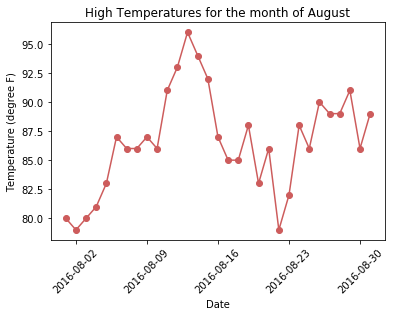

In [72]:
pl.plot(wxTempa['highTemp'], '-o', color ='IndianRed')
pl.title('High Temperatures for the month of August')
pl.xlabel('Date')
pl.ylabel('Temperature (degree F)')
pl.xticks(rotation=45)

##### Figure 3: High Temperatures plotted for the month of August.

(array([ 735965.,  735972.,  735979.,  735986.,  735993.]),
 <a list of 5 Text xticklabel objects>)

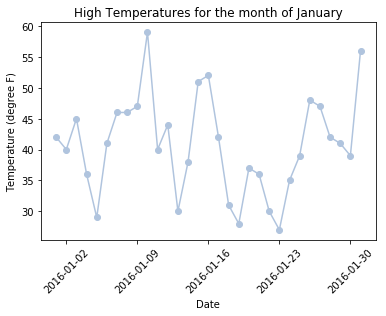

In [73]:
pl.plot(wxTempj['highTemp'], '-o', color ='lightsteelblue')
pl.title('High Temperatures for the month of January')
pl.xlabel('Date')
pl.ylabel('Temperature (degree F)')
pl.xticks(rotation=45)

##### Figure 4: High Temperatures plotted for the month of January.

(array([ 736178.,  736185.,  736192.,  736199.,  736206.]),
 <a list of 5 Text xticklabel objects>)

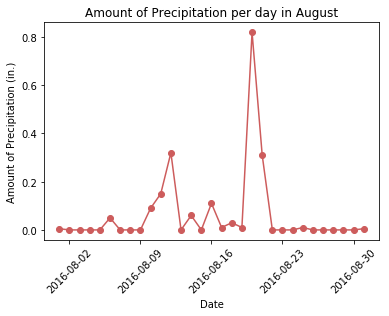

In [74]:
pl.plot(wxTempa['precip'],'-o',color ='IndianRed')
pl.title('Amount of Precipitation per day in August')
pl.xlabel('Date')
pl.ylabel('Amount of Precipitation (in.)')
pl.xticks(rotation=45)

##### Figure 5: Precipitation Amounts (in.) plotted for the month of August.

(array([ 735965.,  735972.,  735979.,  735986.,  735993.]),
 <a list of 5 Text xticklabel objects>)

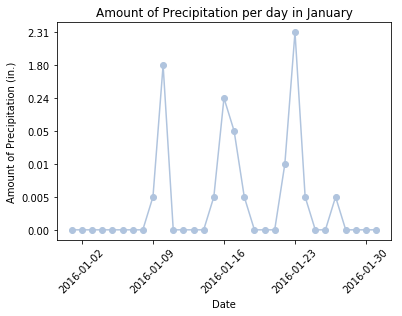

In [75]:
pl.plot(wxTempj['precip'],'-o',color ='lightsteelblue')
pl.title('Amount of Precipitation per day in January')
pl.xlabel('Date')
pl.ylabel('Amount of Precipitation (in.)')
pl.xticks(rotation=45)

##### Figure 6: Precipitation amounts (in.) plotted for the month of January.

(array([ 735965.,  735972.,  735979.,  735986.,  735993.]),
 <a list of 5 Text xticklabel objects>)

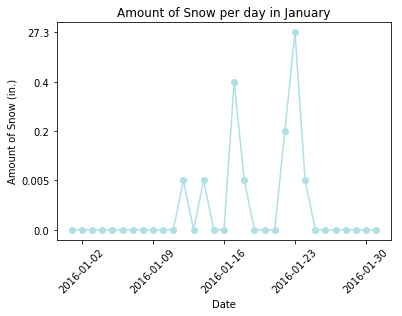

In [76]:
pl.plot(wxTempj['snow'],'-o',color ='powderblue')
pl.title('Amount of Snow per day in January')
pl.xlabel('Date')
pl.ylabel('Amount of Snow (in.)')
pl.xticks(rotation=45)

##### Figure 7: Snowfall totals (in.) plotted for the month of January.

#### Create 4 new DataFrames
##### 1) Select Days in August that are above 90 degrees
##### 2) Select Days in January that are below _____
##### 3) Days in August that got precipitation
##### 4) Select Days in January that got precipitation
##### 5) Select Days in January that got snow

In [77]:
augSelect_temp = wxTempa[wxTempa['highTemp'] > 90]
augSelect_temp

,highTemp,precip
date,,
2016-08-11,91.0,0.15
2016-08-12,93.0,0.32
2016-08-13,96.0,0.00
2016-08-14,94.0,0.06
2016-08-15,92.0,0.00
2016-08-29,91.0,0.00


In [78]:
janSelect_temp = wxTempj[wxTempj['highTemp'] < 35]
janSelect_temp

,highTemp,precip,snow
date,,,
2016-01-05,29.0,0.00,0.0
2016-01-13,30.0,0.00,0.0
2016-01-18,31.0,0.005,0.005
2016-01-19,28.0,0.00,0.0
2016-01-22,30.0,0.01,0.2
2016-01-23,27.0,2.31,27.3


In [79]:
# convert precip and snow to floats
wxTempa['precip'] = pd.to_numeric(wxTempa['precip'], errors='coerce')
wxTempj['precip'] = pd.to_numeric(wxTempj['precip'], errors='coerce')
wxTempj['snow'] = pd.to_numeric(wxTempj['snow'], errors='coerce')

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [80]:
augSelect_pre = wxTempa[wxTempa['precip'] >= 0.1]
augSelect_pre

,highTemp,precip
date,,
2016-08-11,91.0,0.15
2016-08-12,93.0,0.32
2016-08-16,87.0,0.11
2016-08-20,83.0,0.82
2016-08-21,86.0,0.31


In [81]:
janSelect_pre = wxTempj[wxTempj['precip'] > 0.1]
janSelect_pre

,highTemp,precip,snow
date,,,
2016-01-10,59.0,1.80,0.0
2016-01-16,52.0,0.24,0.0
2016-01-23,27.0,2.31,27.3


In [82]:
janSelect_snow = wxTempj[wxTempj['snow'] > 0.005]
janSelect_snow

,highTemp,precip,snow
date,,,
2016-01-17,42.0,0.05,0.4
2016-01-22,30.0,0.01,0.2
2016-01-23,27.0,2.31,27.3


#### Merge the days of 'extreme weather' to the taxi dataset
##### 1) August Temp
##### 2) August Precip
##### 3) Jan. Temp
##### 4) Jan. Precip
##### 5) Jan. snow?!?

In [83]:
augSelect_temp.shape

(6, 2)

In [84]:
augMergeT = augFinal.merge(augSelect_temp, right_on = 'highTemp',
                             left_on = 'highTemp')
augMergeT.head()

,date,highTemp,precip_x,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration,precip_y
0,2016-08-11,91.0,0.15,2,2,1.06,8.16,4.116667,0.15
1,2016-08-11,91.0,0.15,2,2,1.06,8.16,4.116667,0.00
2,2016-08-11,91.0,0.15,2,1,1.89,13.56,13.066667,0.15
3,2016-08-11,91.0,0.15,2,1,1.89,13.56,13.066667,0.00
4,2016-08-11,91.0,0.15,1,1,1.10,8.80,8.933333,0.15


In [86]:
augMergeT.drop(['precip_y'], inplace = True, axis = 1)
augMergeT.columns = ['date', 'temp', 'precip', 'VenderID', 'numPassengers',
                   'tripDistance', 'fareAmount','tripDuration']

ValueError: labels ['precip_y'] not contained in axis

In [87]:
print ("the merge 'extreme weather temp in Aug.' dataset is {:d} observations by {:d} variables".\
           format(*augMergeT.shape))

the merge 'extreme weather temp in Aug.' dataset is 3023 observations by 8 variables


In [88]:
augSelect_pre.columns

Index(['highTemp', 'precip'], dtype='object')

In [89]:
augFinal.dtypes

date                object
highTemp           float64
precip              object
﻿VendorID            int64
passenger_count      int64
trip_distance      float64
total_amount       float64
tripDuration       float64
dtype: object

In [90]:
augFinal['precip'] = pd.to_numeric(augFinal['precip'], errors='coerce')
janFinal['precip'] = pd.to_numeric(janFinal['precip'], errors='coerce')
augFinallong['precip'] = pd.to_numeric(augFinallong['precip'], 
                                       errors='coerce')
janFinallong['precip'] = pd.to_numeric(janFinallong['precip'], 
                                       errors='coerce')

In [91]:
augMergeP = augFinal.merge(augSelect_pre, right_on = 'precip',
                           left_on = 'precip')
augMergeP.head()

,date,highTemp_x,precip,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration,highTemp_y
0,2016-08-11,91.0,0.15,2,2,1.06,8.16,4.116667,91.0
1,2016-08-11,91.0,0.15,2,1,1.89,13.56,13.066667,91.0
2,2016-08-11,91.0,0.15,1,1,1.10,8.80,8.933333,91.0
3,2016-08-11,91.0,0.15,2,1,0.67,7.56,4.900000,91.0
4,2016-08-11,91.0,0.15,2,1,1.20,10.56,8.433333,91.0


In [92]:
augMergeP.drop(['highTemp_y'], inplace = True, axis = 1)
augMergeP.columns = ['date', 'temp', 'precip', 'VenderID', 'numPassengers',
                   'tripDistance', 'fareAmount','tripDuration']

In [93]:
print ("the merge 'extreme weather precip in Aug' dataset is {:d} observations by {:d} variables".\
           format(*augMergeP.shape))

the merge 'extreme weather precip in Aug' dataset is 1945 observations by 8 variables


In [94]:
janMergeT = janFinal.merge(janSelect_temp, right_on = 'highTemp',
                             left_on = 'highTemp')
janMergeT.head()

,date,highTemp,precip_x,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration,precip_y,snow
0,2016-01-05,29.0,0.0,2,2,1.22,8.8,8.766667,0.00,0.0
1,2016-01-05,29.0,0.0,2,1,1.10,7.3,4.683333,0.00,0.0
2,2016-01-05,29.0,0.0,1,4,1.70,9.3,6.933333,0.00,0.0
3,2016-01-05,29.0,0.0,2,1,0.57,5.3,2.950000,0.00,0.0
4,2016-01-05,29.0,0.0,1,1,0.60,6.8,5.866667,0.00,0.0


In [96]:
janMergeT.drop(['precip_y'], inplace = True, axis = 1)
janMergeT.columns = ['date', 'temp', 'precip', 'VenderID', 'numPassengers',
                   'tripDistance', 'fareAmount','tripDuration','snow']
janMergeT.head()

ValueError: labels ['precip_y'] not contained in axis

In [97]:
print ("the merge 'extreme weather temp in Jan.' dataset is {:d} observations by {:d} variables".\
           format(*janMergeT.shape))

the merge 'extreme weather temp in Jan.' dataset is 3300 observations by 9 variables


In [98]:
janMergeP = janFinal.merge(janSelect_pre, right_on = 'precip',
                           left_on = 'precip')
janMergeP.head()

,date,highTemp_x,precip,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration,highTemp_y,snow
0,2016-01-10,59.0,1.8,2,4,0.61,5.80,3.750000,59.0,0.0
1,2016-01-10,59.0,1.8,1,1,0.60,5.80,3.716667,59.0,0.0
2,2016-01-10,59.0,1.8,1,1,0.90,8.75,6.533333,59.0,0.0
3,2016-01-10,59.0,1.8,1,1,1.30,11.60,9.300000,59.0,0.0
4,2016-01-10,59.0,1.8,2,3,1.35,8.30,7.066667,59.0,0.0


In [99]:
janMergeP.drop(['highTemp_y'], inplace = True, axis = 1)
janMergeP.columns = ['date', 'temp', 'precip', 'VenderID', 'numPassengers',
                   'tripDistance', 'fareAmount','tripDuration','snow']

In [100]:
janMergeP.head()

,date,temp,precip,VenderID,numPassengers,tripDistance,fareAmount,tripDuration,snow
0,2016-01-10,59.0,1.8,2,4,0.61,5.80,3.750000,0.0
1,2016-01-10,59.0,1.8,1,1,0.60,5.80,3.716667,0.0
2,2016-01-10,59.0,1.8,1,1,0.90,8.75,6.533333,0.0
3,2016-01-10,59.0,1.8,1,1,1.30,11.60,9.300000,0.0
4,2016-01-10,59.0,1.8,2,3,1.35,8.30,7.066667,0.0


In [101]:
print ("the merge 'extreme weather precip' dataset is {:d} observations by {:d} variables".\
           format(*janMergeP.shape))

the merge 'extreme weather precip' dataset is 940 observations by 9 variables


###### merge the long distance datasets with temp and precip

In [102]:
augMergeTlong = augFinallong.merge(augSelect_temp, right_on = 'highTemp',
                             left_on = 'highTemp')
augMergeTlong.head()

,date,highTemp,precip_x,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration,precip_y
0,2016-08-11,91.0,0.15,2,1,5.86,26.16,21.866667,0.15
1,2016-08-11,91.0,0.15,2,1,5.86,26.16,21.866667,0.00
2,2016-08-11,91.0,0.15,1,1,3.60,20.15,19.850000,0.15
3,2016-08-11,91.0,0.15,1,1,3.60,20.15,19.850000,0.00
4,2016-08-11,91.0,0.15,2,1,3.10,17.76,15.383333,0.15


In [103]:
augMergeTlong.drop(['precip_y'], inplace = True, axis = 1)
augMergeTlong.columns = ['date', 'temp', 'precip', 'VenderID', 'numPassengers',
                   'tripDistance', 'fareAmount','tripDuration']

In [104]:
print ("the merge 'extreme weather temp in Aug. long' \
dataset is {:d} observations by {:d} variables".\
           format(*augMergeTlong.shape))

the merge 'extreme weather temp in Aug. long' dataset is 2171 observations by 8 variables


In [105]:
augMergePlong = augFinallong.merge(augSelect_pre, right_on = 'precip',
                           left_on = 'precip')
augMergePlong.head()

,date,highTemp_x,precip,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration,highTemp_y
0,2016-08-11,91.0,0.15,2,1,5.86,26.16,21.866667,91.0
1,2016-08-11,91.0,0.15,1,1,3.60,20.15,19.850000,91.0
2,2016-08-11,91.0,0.15,2,1,3.10,17.76,15.383333,91.0
3,2016-08-11,91.0,0.15,1,1,2.20,13.55,11.583333,91.0
4,2016-08-11,91.0,0.15,2,2,6.46,28.80,34.683333,91.0


In [106]:
augMergePlong.drop(['highTemp_y'], inplace = True, axis = 1)
augMergeP.columns = ['date', 'temp', 'precip', 'VenderID', 'numPassengers',
                   'tripDistance', 'fareAmount','tripDuration']

In [107]:
print ("the merge 'extreme weather precip in Aug long' dataset is {:d} observations by {:d} variables".\
           format(*augMergePlong.shape))

the merge 'extreme weather precip in Aug long' dataset is 1382 observations by 8 variables


In [108]:
janMergeTlong = janFinallong.merge(janSelect_temp, right_on = 'highTemp',
                             left_on = 'highTemp')
janMergeTlong.head()

,date,highTemp,precip_x,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration,precip_y,snow
0,2016-01-05,29.0,0.0,1,1,18.30,60.95,24.216667,0.00,0.0
1,2016-01-05,29.0,0.0,1,1,8.20,28.80,29.116667,0.00,0.0
2,2016-01-05,29.0,0.0,1,1,9.00,35.30,29.700000,0.00,0.0
3,2016-01-05,29.0,0.0,1,1,6.00,24.75,17.766667,0.00,0.0
4,2016-01-05,29.0,0.0,2,1,6.54,23.80,24.650000,0.00,0.0


In [109]:
janMergeTlong.drop(['precip_y'], inplace = True, axis = 1)
janMergeTlong.columns = ['date', 'temp', 'precip', 'VenderID', 'numPassengers',
                   'tripDistance', 'fareAmount','tripDuration','snow']
janMergeTlong.head()

,date,temp,precip,VenderID,numPassengers,tripDistance,fareAmount,tripDuration,snow
0,2016-01-05,29.0,0.0,1,1,18.30,60.95,24.216667,0.0
1,2016-01-05,29.0,0.0,1,1,8.20,28.80,29.116667,0.0
2,2016-01-05,29.0,0.0,1,1,9.00,35.30,29.700000,0.0
3,2016-01-05,29.0,0.0,1,1,6.00,24.75,17.766667,0.0
4,2016-01-05,29.0,0.0,2,1,6.54,23.80,24.650000,0.0


In [110]:
print ("the merge 'extreme weather temp in Jan. long' dataset is {:d} observations by {:d} variables".\
           format(*janMergeTlong.shape))

the merge 'extreme weather temp in Jan. long' dataset is 2187 observations by 9 variables


In [111]:
janMergePlong = janFinallong.merge(janSelect_pre, right_on = 'precip',
                           left_on = 'precip')
janMergePlong.head()

,date,highTemp_x,precip,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration,highTemp_y,snow
0,2016-01-10,59.0,1.8,1,1,2.50,13.80,12.666667,59.0,0.0
1,2016-01-10,59.0,1.8,2,2,5.80,27.30,28.783333,59.0,0.0
2,2016-01-10,59.0,1.8,1,1,3.60,13.80,12.183333,59.0,0.0
3,2016-01-10,59.0,1.8,2,2,2.35,13.56,9.900000,59.0,0.0
4,2016-01-10,59.0,1.8,2,1,3.11,15.30,15.066667,59.0,0.0


In [112]:
janMergePlong.drop(['highTemp_y'], inplace = True, axis = 1)
janMergePlong.columns = ['date', 'temp', 'precip', 'VenderID', 'numPassengers',
                   'tripDistance', 'fareAmount','tripDuration','snow']
janMergePlong.head()

,date,temp,precip,VenderID,numPassengers,tripDistance,fareAmount,tripDuration,snow
0,2016-01-10,59.0,1.8,1,1,2.50,13.80,12.666667,0.0
1,2016-01-10,59.0,1.8,2,2,5.80,27.30,28.783333,0.0
2,2016-01-10,59.0,1.8,1,1,3.60,13.80,12.183333,0.0
3,2016-01-10,59.0,1.8,2,2,2.35,13.56,9.900000,0.0
4,2016-01-10,59.0,1.8,2,1,3.11,15.30,15.066667,0.0


In [113]:
print ("the merge 'extreme weather precip' dataset is {:d} observations by {:d} variables".\
           format(*janMergePlong.shape))

the merge 'extreme weather precip' dataset is 721 observations by 9 variables


In [114]:
augMergeTlong.columns

Index(['date', 'temp', 'precip', 'VenderID', 'numPassengers', 'tripDistance',
       'fareAmount', 'tripDuration'],
      dtype='object')

In [115]:
augMergeTlong.columns = ['data','temp','precip', 'VenderID', 'numPassengers',
                        'distanceLong','fareAmount','tripDuration']
augMergeTlong.head()

,data,temp,precip,VenderID,numPassengers,distanceLong,fareAmount,tripDuration
0,2016-08-11,91.0,0.15,2,1,5.86,26.16,21.866667
1,2016-08-11,91.0,0.15,2,1,5.86,26.16,21.866667
2,2016-08-11,91.0,0.15,1,1,3.60,20.15,19.850000
3,2016-08-11,91.0,0.15,1,1,3.60,20.15,19.850000
4,2016-08-11,91.0,0.15,2,1,3.10,17.76,15.383333


In [116]:
janMergeT.head()

,date,highTemp,precip_x,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration,snow
0,2016-01-05,29.0,0.0,2,2,1.22,8.8,8.766667,0.0
1,2016-01-05,29.0,0.0,2,1,1.10,7.3,4.683333,0.0
2,2016-01-05,29.0,0.0,1,4,1.70,9.3,6.933333,0.0
3,2016-01-05,29.0,0.0,2,1,0.57,5.3,2.950000,0.0
4,2016-01-05,29.0,0.0,1,1,0.60,6.8,5.866667,0.0


In [118]:
augMergeFinal = augMergeTlong.merge(augMergeT, right_on = 'highTemp',
                             left_on = 'temp')
augMergeFinal.head()

,data,temp,precip,VenderID,numPassengers,distanceLong,fareAmount,tripDuration_x,date,highTemp,precip_x,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration_y
0,2016-08-11,91.0,0.15,2,1,5.86,26.16,21.866667,2016-08-11,91.0,0.15,2,2,1.06,8.16,4.116667
1,2016-08-11,91.0,0.15,2,1,5.86,26.16,21.866667,2016-08-11,91.0,0.15,2,2,1.06,8.16,4.116667
2,2016-08-11,91.0,0.15,2,1,5.86,26.16,21.866667,2016-08-11,91.0,0.15,2,1,1.89,13.56,13.066667
3,2016-08-11,91.0,0.15,2,1,5.86,26.16,21.866667,2016-08-11,91.0,0.15,2,1,1.89,13.56,13.066667
4,2016-08-11,91.0,0.15,2,1,5.86,26.16,21.866667,2016-08-11,91.0,0.15,1,1,1.10,8.80,8.933333


In [123]:
augMergeFinal.columns

Index(['temp', 'precip', 'VenderID', 'numPassengers', 'distanceLong',
       'fareAmount', 'date', '﻿VendorID', 'passenger_count', 'trip_distance',
       'total_amount', 'tripDuration_y'],
      dtype='object')

In [125]:
janMergeFinal = janMergeTlong.merge(janMergeT, right_on = 'highTemp',
                             left_on = 'temp')
janMergeFinal.head()

,date_x,temp,precip,VenderID,numPassengers,tripDistance,fareAmount,tripDuration_x,snow_x,date_y,highTemp,precip_x,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration_y,snow_y
0,2016-01-05,29.0,0.0,1,1,18.3,60.95,24.216667,0.0,2016-01-05,29.0,0.0,2,2,1.22,8.8,8.766667,0.0
1,2016-01-05,29.0,0.0,1,1,18.3,60.95,24.216667,0.0,2016-01-05,29.0,0.0,2,1,1.10,7.3,4.683333,0.0
2,2016-01-05,29.0,0.0,1,1,18.3,60.95,24.216667,0.0,2016-01-05,29.0,0.0,1,4,1.70,9.3,6.933333,0.0
3,2016-01-05,29.0,0.0,1,1,18.3,60.95,24.216667,0.0,2016-01-05,29.0,0.0,2,1,0.57,5.3,2.950000,0.0
4,2016-01-05,29.0,0.0,1,1,18.3,60.95,24.216667,0.0,2016-01-05,29.0,0.0,1,1,0.60,6.8,5.866667,0.0


In [126]:
janMergeFinal.drop(['date_x','precip_x',
                   'tripDuration_x', 'snow_x',
                   'snow_y'], inplace = True,
                   axis = 1)


In [127]:
janMergeFinal.head()

,temp,precip,VenderID,numPassengers,tripDistance,fareAmount,date_y,highTemp,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration_y
0,29.0,0.0,1,1,18.3,60.95,2016-01-05,29.0,2,2,1.22,8.8,8.766667
1,29.0,0.0,1,1,18.3,60.95,2016-01-05,29.0,2,1,1.10,7.3,4.683333
2,29.0,0.0,1,1,18.3,60.95,2016-01-05,29.0,1,4,1.70,9.3,6.933333
3,29.0,0.0,1,1,18.3,60.95,2016-01-05,29.0,2,1,0.57,5.3,2.950000
4,29.0,0.0,1,1,18.3,60.95,2016-01-05,29.0,1,1,0.60,6.8,5.866667


In [128]:
janMergeFinal.columns

Index(['temp', 'precip', 'VenderID', 'numPassengers', 'tripDistance',
       'fareAmount', 'date_y', 'highTemp', '﻿VendorID', 'passenger_count',
       'trip_distance', 'total_amount', 'tripDuration_y'],
      dtype='object')

#### Run Linear Regressions on the variables
##### 1) August Temperatures vs. August Precip on extreme weather days
##### 2) Jan Temps vs. Jan precip on extreme wx days
##### 3) August Temperatures vs. Jan Temps on extreme ex days
##### 4) Aug Precip vs Jan precip
##### 5) run ztest?
##### 6) run regression on all days of month?

In [130]:
augMergeT.head()

,date,highTemp,precip_x,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration
0,2016-08-11,91.0,0.15,2,2,1.06,8.16,4.116667
1,2016-08-11,91.0,0.15,2,2,1.06,8.16,4.116667
2,2016-08-11,91.0,0.15,2,1,1.89,13.56,13.066667
3,2016-08-11,91.0,0.15,2,1,1.89,13.56,13.066667
4,2016-08-11,91.0,0.15,1,1,1.10,8.80,8.933333


In [131]:
# regression on August temps and August Precip
#dependent variable = temperature

lmAugT = smf.ols(formula = 'highTemp ~  precip_x', data = augMergeT).fit()
lmAugT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               highTemp   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     440.8
Date:                Thu, 14 Dec 2017   Prob (F-statistic):          1.80e-237
Time:                        22:10:58   Log-Likelihood:                -5400.1
No. Observations:                3023   AIC:                         1.081e+04
Df Residuals:                    3019   BIC:                         1.083e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           92.6486      0.039   2399.149      0.000        92.573    92.724
precip_x[T.0.06]     1.3514      0.090     15.095      0.000         1.176     1.527
precip_x[T.0.15]    -1.6486      0.062    -26.410      0.000        -1.771    -1.526
precip_x[T.0.32]     0.3514      0.079      4.431      0.000         0.196     0.507
==============================================================================
Omnibus:                      583.749   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              983.819
Skew:                           1.281   Prob(JB):                    2.33e-214
Kurtosis:                       4.115   Cond. No.                         4.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [133]:
augMergeP.head()

,date,temp,precip,VenderID,numPassengers,tripDistance,fareAmount,tripDuration
0,2016-08-11,91.0,0.15,2,2,1.06,8.16,4.116667
1,2016-08-11,91.0,0.15,2,1,1.89,13.56,13.066667
2,2016-08-11,91.0,0.15,1,1,1.10,8.80,8.933333
3,2016-08-11,91.0,0.15,2,1,0.67,7.56,4.900000
4,2016-08-11,91.0,0.15,2,1,1.20,10.56,8.433333


In [134]:
# regression on August Precip and August Temp
#dependent variable = precip

lmAugP = smf.ols(formula = 'precip ~  temp', data = augMergeP).fit()
lmAugP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 precip   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     1089.
Date:                Thu, 14 Dec 2017   Prob (F-statistic):          4.85e-190
Time:                        22:11:31   Log-Likelihood:                 381.36
No. Observations:                1945   AIC:                            -758.7
Df Residuals:                    1943   BIC:                            -747.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.9775      0.111     35.973      0.000         3.761     4.194
temp          -0.0413      0.001    -33.005      0.000        -0.044    -0.039
==============================================================================
Omnibus:                        0.829   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.661   Jarque-Bera (JB):              171.995
Skew:                           0.050   Prob(JB):                     4.48e-38
Kurtosis:                       1.547   Cond. No.                     2.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [137]:
janMergeT.head(1)

,date,highTemp,precip_x,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration,snow
0,2016-01-05,29.0,0.0,2,2,1.22,8.8,8.766667,0.0


In [138]:
# regression on January temps and January Precip
#dependent variable = temperature

lmJanT = smf.ols(formula = 'highTemp ~  precip_x', data = janMergeT).fit()
lmJanT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               highTemp   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     837.5
Date:                Thu, 14 Dec 2017   Prob (F-statistic):          2.70e-164
Time:                        22:11:59   Log-Likelihood:                -4108.7
No. Observations:                3300   AIC:                             8221.
Df Residuals:                    3298   BIC:                             8234.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     29.7209      0.015   2001.646      0.000        29.692    29.750
precip_x      -1.1658      0.040    -28.939      0.000        -1.245    -1.087
==============================================================================
Omnibus:                      259.824   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.607
Skew:                          -0.768   Prob(JB):                     3.26e-71
Kurtosis:                       3.063   Cond. No.                         2.77
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [139]:
janMergeP.head(1)

,date,temp,precip,VenderID,numPassengers,tripDistance,fareAmount,tripDuration,snow
0,2016-01-10,59.0,1.8,2,4,0.61,5.8,3.75,0.0


In [140]:
# regression on January temps and January Precip
#dependent variable = precip

lmJanP = smf.ols(formula = 'temp ~  precip', data = janMergeP).fit()
lmJanP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   temp   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     8.219
Date:                Thu, 14 Dec 2017   Prob (F-statistic):            0.00424
Time:                        22:12:17   Log-Likelihood:                -3361.9
No. Observations:                 940   AIC:                             6728.
Df Residuals:                     938   BIC:                             6737.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     53.6528      0.456    117.592      0.000        52.757    54.548
precip        -0.9671      0.337     -2.867      0.004        -1.629    -0.305
==============================================================================
Omnibus:                      317.373   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              821.173
Skew:                          -1.788   Prob(JB):                    4.84e-179
Kurtosis:                       5.860   Cond. No.                         3.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [144]:
augMergeFinal.head(1)

,temp,precip,VenderID,numPassengers,distanceLong,fareAmount,date,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration_y
0,91.0,0.15,2,1,5.86,26.16,2016-08-11,2,2,1.06,8.16,4.116667


In [145]:
# regression between August short and August Long Temperatures

lmAugall = smf.ols(formula = 'distanceLong ~  trip_distance', 
                   data = augMergeFinal).fit()
lmAugall.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           distanceLong   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.03131
Date:                Thu, 14 Dec 2017   Prob (F-statistic):              0.860
Time:                        22:17:40   Log-Likelihood:            -6.0863e+06
No. Observations:             2065167   AIC:                         1.217e+07
Df Residuals:                 2065165   BIC:                         1.217e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         5.7272      0.008    694.649      0.000         5.711     5.743
trip_distance    -0.0012      0.007     -0.177      0.860        -0.015     0.012
==============================================================================
Omnibus:                   840368.937   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3432448.358
Skew:                           2.035   Prob(JB):                         0.00
Kurtosis:                       7.830   Cond. No.                         5.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [146]:
augMergeFinal.head(1)

,temp,precip,VenderID,numPassengers,distanceLong,fareAmount,date,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration_y
0,91.0,0.15,2,1,5.86,26.16,2016-08-11,2,2,1.06,8.16,4.116667


In [147]:
# regression between August short and August Long Temperatures

lmAugall2 = smf.ols(formula = 'trip_distance ~  distanceLong', 
                   data = augMergeFinal).fit()
lmAugall2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_distance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.03131
Date:                Thu, 14 Dec 2017   Prob (F-statistic):              0.860
Time:                        22:18:14   Log-Likelihood:            -1.3663e+06
No. Observations:             2065167   AIC:                         2.733e+06
Df Residuals:                 2065165   BIC:                         2.733e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        1.1103      0.001   2133.902      0.000         1.109     1.111
distanceLong -1.252e-05   7.08e-05     -0.177      0.860        -0.000     0.000
==============================================================================
Omnibus:                   148349.043   Durbin-Watson:                   1.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51534.711
Skew:                           0.067   Prob(JB):                         0.00
Kurtosis:                       2.238   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [148]:
# regression between aug. short distance and temp

lmAugall3 = smf.ols(formula = 'trip_distance ~  temp', 
                   data = augMergeFinal).fit()
lmAugall3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_distance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     336.1
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           4.53e-75
Time:                        22:18:41   Log-Likelihood:            -1.3661e+06
No. Observations:             2065167   AIC:                         2.732e+06
Df Residuals:                 2065165   BIC:                         2.732e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.6884      0.023     29.916      0.000         0.643     0.733
temp           0.0046      0.000     18.334      0.000         0.004     0.005
==============================================================================
Omnibus:                   147278.706   Durbin-Watson:                   1.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51360.415
Skew:                           0.068   Prob(JB):                         0.00
Kurtosis:                       2.239   Cond. No.                     6.46e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [149]:
# regression between aug long distance and temp

lmAugall4 = smf.ols(formula = 'distanceLong ~  temp', 
                   data = augMergeFinal).fit()
lmAugall4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           distanceLong   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1446.
Date:                Thu, 14 Dec 2017   Prob (F-statistic):          3.10e-316
Time:                        22:18:42   Log-Likelihood:            -6.0856e+06
No. Observations:             2065167   AIC:                         1.217e+07
Df Residuals:                 2065165   BIC:                         1.217e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     14.3244      0.226     63.337      0.000        13.881    14.768
temp          -0.0939      0.002    -38.023      0.000        -0.099    -0.089
==============================================================================
Omnibus:                   839341.226   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3422234.095
Skew:                           2.033   Prob(JB):                         0.00
Kurtosis:                       7.821   Cond. No.                     6.46e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [150]:
# regression between aug long distance and temp

lmAugall5 = smf.ols(formula = 'trip_distance ~  temp', 
                   data = augMergeFinal).fit()
lmAugall5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_distance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     336.1
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           4.53e-75
Time:                        22:18:51   Log-Likelihood:            -1.3661e+06
No. Observations:             2065167   AIC:                         2.732e+06
Df Residuals:                 2065165   BIC:                         2.732e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.6884      0.023     29.916      0.000         0.643     0.733
temp           0.0046      0.000     18.334      0.000         0.004     0.005
==============================================================================
Omnibus:                   147278.706   Durbin-Watson:                   1.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51360.415
Skew:                           0.068   Prob(JB):                         0.00
Kurtosis:                       2.239   Cond. No.                     6.46e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [151]:
janMergeFinal.head(1)

,temp,precip,VenderID,numPassengers,tripDistance,fareAmount,date_y,highTemp,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration_y
0,29.0,0.0,1,1,18.3,60.95,2016-01-05,29.0,2,2,1.22,8.8,8.766667


In [152]:
# regression between Jan short and Jan Long Temperatures

lmJanall = smf.ols(formula = 'tripDistance ~  trip_distance', 
                   data = janMergeFinal).fit()
lmJanall.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           tripDistance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2927
Date:                Thu, 14 Dec 2017   Prob (F-statistic):              0.588
Time:                        22:19:32   Log-Likelihood:            -8.2297e+06
No. Observations:             2838655   AIC:                         1.646e+07
Df Residuals:                 2838653   BIC:                         1.646e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         5.2642      0.007    782.332      0.000         5.251     5.277
trip_distance     0.0030      0.006      0.541      0.588        -0.008     0.014
==============================================================================
Omnibus:                  2887040.115   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        696187388.660
Skew:                           4.550   Prob(JB):                         0.00
Kurtosis:                      79.179   Cond. No.                         5.05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [153]:
# regression between jan. short distance and temp

lmJanall2 = smf.ols(formula = 'trip_distance ~  temp', 
                   data = janMergeFinal).fit()
lmJanall2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_distance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     526.8
Date:                Thu, 14 Dec 2017   Prob (F-statistic):          1.43e-116
Time:                        22:19:57   Log-Likelihood:            -1.8625e+06
No. Observations:             2838655   AIC:                         3.725e+06
Df Residuals:                 2838653   BIC:                         3.725e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.4678      0.016     93.962      0.000         1.437     1.498
temp          -0.0120      0.001    -22.952      0.000        -0.013    -0.011
==============================================================================
Omnibus:                   167661.183   Durbin-Watson:                   1.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            64884.639
Skew:                           0.090   Prob(JB):                         0.00
Kurtosis:                       2.282   Cond. No.                     1.69e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [154]:
# regression between jan long distance and temp

lmJanall3 = smf.ols(formula = 'tripDistance ~  temp', 
                   data = janMergeFinal).fit()
lmJanall3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           tripDistance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     13.60
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           0.000226
Time:                        22:20:08   Log-Likelihood:            -8.2297e+06
No. Observations:             2838655   AIC:                         1.646e+07
Df Residuals:                 2838653   BIC:                         1.646e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      5.8103      0.147     39.477      0.000         5.522     6.099
temp          -0.0182      0.005     -3.688      0.000        -0.028    -0.009
==============================================================================
Omnibus:                  2887587.947   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        697071986.691
Skew:                           4.551   Prob(JB):                         0.00
Kurtosis:                      79.228   Cond. No.                     1.69e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [155]:
janMergeFinal.head(1)

,temp,precip,VenderID,numPassengers,tripDistance,fareAmount,date_y,highTemp,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration_y
0,29.0,0.0,1,1,18.3,60.95,2016-01-05,29.0,2,2,1.22,8.8,8.766667


In [156]:
# regression between aug long distance and temp

lmJanall4 = smf.ols(formula = 'trip_distance ~  temp', 
                   data = janMergeFinal).fit()
lmJanall4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_distance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     526.8
Date:                Thu, 14 Dec 2017   Prob (F-statistic):          1.43e-116
Time:                        22:20:43   Log-Likelihood:            -1.8625e+06
No. Observations:             2838655   AIC:                         3.725e+06
Df Residuals:                 2838653   BIC:                         3.725e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.4678      0.016     93.962      0.000         1.437     1.498
temp          -0.0120      0.001    -22.952      0.000        -0.013    -0.011
==============================================================================
Omnibus:                   167661.183   Durbin-Watson:                   1.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            64884.639
Skew:                           0.090   Prob(JB):                         0.00
Kurtosis:                       2.282   Cond. No.                     1.69e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.69e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
# regression between jan short distance and temp

lmJanall5 = smf.ols(formula = 'trip_distance ~  temp + precip', 
                   data = janMergeFinal).fit()
lmJanall5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_distance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     264.3
Date:                Thu, 14 Dec 2017   Prob (F-statistic):          1.75e-115
Time:                        22:21:07   Log-Likelihood:            -1.8625e+06
No. Observations:             2838655   AIC:                         3.725e+06
Df Residuals:                 2838652   BIC:                         3.725e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.4728      0.016     91.522      0.000         1.441     1.504
temp          -0.0122      0.001    -22.600      0.000        -0.013    -0.011
precip        -0.0035      0.003     -1.308      0.191        -0.009     0.002
==============================================================================
Omnibus:                   167665.613   Durbin-Watson:                   1.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            64884.735
Skew:                           0.090   Prob(JB):                         0.00
Kurtosis:                       2.282   Cond. No.                     1.74e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [158]:
augMergeFinal.head(1)

,temp,precip,VenderID,numPassengers,distanceLong,fareAmount,date,﻿VendorID,passenger_count,trip_distance,total_amount,tripDuration_y
0,91.0,0.15,2,1,5.86,26.16,2016-08-11,2,2,1.06,8.16,4.116667


In [159]:
# regression between aug short distance and temp

lmAugall6 = smf.ols(formula = 'trip_distance ~  temp + precip', 
                   data = augMergeFinal).fit()
lmAugall6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_distance   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     187.0
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           5.99e-82
Time:                        22:21:28   Log-Likelihood:            -1.3661e+06
No. Observations:             2065167   AIC:                         2.732e+06
Df Residuals:                 2065164   BIC:                         2.732e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.6933      0.023     30.111      0.000         0.648     0.738
temp           0.0046      0.000     18.199      0.000         0.004     0.005
precip        -0.0218      0.004     -6.161      0.000        -0.029    -0.015
==============================================================================
Omnibus:                   147129.584   Durbin-Watson:                   1.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51331.510
Skew:                           0.068   Prob(JB):                         0.00
Kurtosis:                       2.240   Cond. No.                     6.46e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""